In [1]:
import os, glob, shutil
import mne
import numpy as np
import scipy.io as io
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py

from mne.baseline import rescale
from mne.time_frequency import tfr_array_multitaper

In [2]:
# variables
subj = 'sub-001'
bids_dir = '/Users/knapen/projects/prf-seeg/data/bids'
derivatives_dir = '/Users/knapen/projects/prf-seeg/data/derivatives'
analysis_stage = 'preprocessing'

run = 3
target_el = 'N'

durations_one_pRF_expt = np.array([2, 6, 6, 2, 6, 6, 2, 6, 6, 2, 6, 6, 2])
expts_in_run = 6

bar_blank_bools = np.array([0,1,1]*4+[0], dtype=bool)

In [3]:
edf_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_acq-2kHz.edf'
raw_data = mne.io.read_raw_edf(os.path.join(bids_dir, subj, 'func', edf_file))
# /Users/knapen/projects/prf-seeg/data/bids/sub-001/func/sub-001_run-03_task-pRF_acq-2kHz.edf

evt_tsv_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_events.tsv'
fix_tsv_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_fix_responses.tsv'
exp_yml_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_expsettings.yml'
seq_timing_h5_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_seq_timing.h5'
aperture_h5_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_apertures.h5'

Extracting EDF parameters from /Users/knapen/projects/prf-seeg/data/bids/sub-001/func/sub-001_run-03_task-pRF_acq-2kHz.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## Trigger Events
get the trigger events from the 'DC' channels

In [ ]:
blank_channel = 8
bar_channel = 9

dc_channels = [f'POL DC{str(i).zfill(2)}' for i in range(1,17)]
dc_channels_indx = [True if 'POL DC' in ch else False for ch in raw_data.ch_names]

In [ ]:
raw_data.load_data()
raw_data.notch_filter([50,100,150], picks=np.arange(len(dc_channels_indx))[~np.array(dc_channels_indx)])
raw_data.resample(500, stim_picks=dc_channels_indx)

dc_data = raw_data.get_data(picks=dc_channels)

Reading 0 ... 1040031  =      0.000 ...   520.015 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)



In [ ]:
def timings_from_channel(channel_data, ll=4):
    baseline = np.median(channel_data)
    spread = np.std(channel_data)
    overs = channel_data > baseline+ll*spread
    onsets = np.r_[np.diff(overs)>0, False]
    onset_indx = np.arange(channel_data.shape[0])[onsets]
    return onsets, onset_indx


blank_onsets, blank_onset_indx = timings_from_channel(dc_data[blank_channel])
bar_onsets, bar_onset_indx = timings_from_channel(dc_data[bar_channel])

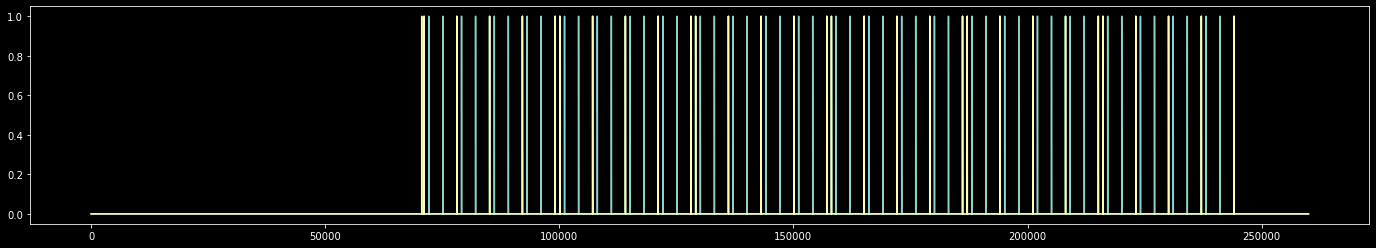

In [ ]:
plt.figure(figsize=(24,4))
plt.plot(bar_onsets)
plt.plot(blank_onsets)
# plt.xlim([250000,1e6])

In [ ]:
data_onset_idx = blank_onset_indx[0]
print(data_onset_idx)
print(raw_data.ch_names)

70603
["POL A'1", "POL A'2", "POL A'3", "POL A'4", "POL A'5", "POL A'6", "POL A'7", "POL A'8", "POL A'9", "POL A'10", "POL A'13", "POL A'14", "POL F'1", "POL F'2", "POL F'3", "POL F'4", "POL F'5", "POL F'6", "POL F'7", 'POL E', "POL F'8", "POL F'9", "POL A'11", "POL A'12", "POL F'10", "POL F'11", "POL F'12", "POL F'13", "POL F'14", "POL F'15", "POL H'1", "POL H'2", "POL H'3", "POL H'4", "POL H'5", "POL H'6", "POL H'7", 'POL DC01', 'POL DC02', 'POL DC03', 'POL DC04', 'POL DC05', 'POL DC06', 'POL DC07', 'POL DC08', 'POL DC09', 'POL DC10', 'POL DC11', 'POL DC12', 'POL DC13', 'POL DC14', 'POL DC15', 'POL DC16', "POL H'8", "POL H'9", "POL H'10", "POL H'11", "POL H'12", "POL H'13", "POL H'14", "POL H'15", "POL H'16", "POL L'1", "POL L'2", "POL L'3", "POL L'4", "POL L'5", "POL L'6", "POL L'7", "POL L'8", "POL L'9", "POL L'10", "POL L'11", "POL L'12", "POL L'13", "POL L'14", "POL L'15", "POL L'16", "POL L'17", "POL L'18", "POL M'1", "POL M'2", "POL M'3", "POL M'4", "POL M'5", "POL M'6", "POL M

In [ ]:
evt_data = pd.read_csv(os.path.join(bids_dir, subj, 'func', evt_tsv_file), sep='\t')
start_time = evt_data[evt_data.event_type == 'pulse'].onset_abs.values[0]
trial_data = evt_data[evt_data.event_type == 'stim'][['bar_direction', 'bar_width', 'bar_refresh_time', 'onset_abs']]
trial_data = trial_data[~np.isnan(trial_data['bar_width'].values)]
trial_data['onset_time'] = trial_data.onset_abs - start_time
trial_data.reindex(index=np.arange(trial_data.shape[0]))

,bar_direction,bar_width,bar_refresh_time,onset_abs,onset_time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,NaN
74,-1.0,-1.0,1.000000,162.407977,131.053134
75,NaN,NaN,NaN,NaN,NaN
76,90.0,0.1,0.066667,164.416487,133.061644


In [ ]:
bar_widths, bar_refresh_times = [0.1, 0.2, 0.3], [0.06666666667, 0.5]

bws, brts = np.meshgrid(bar_widths, bar_refresh_times)
bws, brts = bws.ravel(), brts.ravel()
order = np.arange(bws.shape[0])
np.random.shuffle(order)

print(bws, brts, order)

[0.1 0.2 0.3 0.1 0.2 0.3] [0.06666667 0.06666667 0.06666667 0.5        0.5        0.5       ] [3 5 2 1 4 0]


[1, 14, 27, 40, 53, 66]


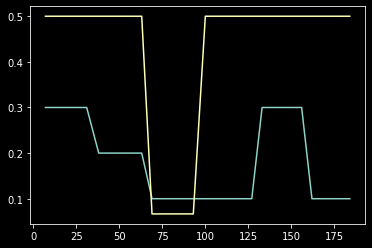

In [ ]:
bar_widths = [trial_data.iloc[durations_one_pRF_expt.shape[0]*i+1].bar_width for i in range(expts_in_run)]
bar_refresh_times = [trial_data.iloc[durations_one_pRF_expt.shape[0]*i+1].bar_refresh_time for i in range(expts_in_run)]

print([durations_one_pRF_expt.shape[0]*i+1 for i in range(expts_in_run)])


plt.plot(trial_data.bar_width[trial_data.bar_width>0])
plt.plot(trial_data.bar_refresh_time[trial_data.bar_width>0])

## Now, get data from all other channels
the non-DC channels should contain signals

In [ ]:
# raw_data.chnames
data_channels = [ch for ch in raw_data.ch_names if f'POL {target_el}' in ch]

# data_channels = [ch for ch in raw_data.ch_names if ch not in dc_channels]
raw_data_np = raw_data.get_data(picks=data_channels, start=data_onset_idx)

In [ ]:
freqs = np.logspace(0.3, 2.3, 200)

tfr_data = tfr_array_multitaper(
    raw_data_np[np.newaxis, ...], sfreq=500, freqs=freqs, n_jobs=4, decim=5, output='power')


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  1.6min finished


In [ ]:
dfs = [pd.DataFrame(tfr_data[0,el].T, columns=freqs, index=np.arange(0,tfr_data.shape[-1]*0.01, 0.01)) for el in np.arange(tfr_data.shape[1])]
for i, df in enumerate(dfs):
    df.to_hdf(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', '_tfr.h5')), key=f'{target_el}_{str(i).zfill(2)}', mode='a')


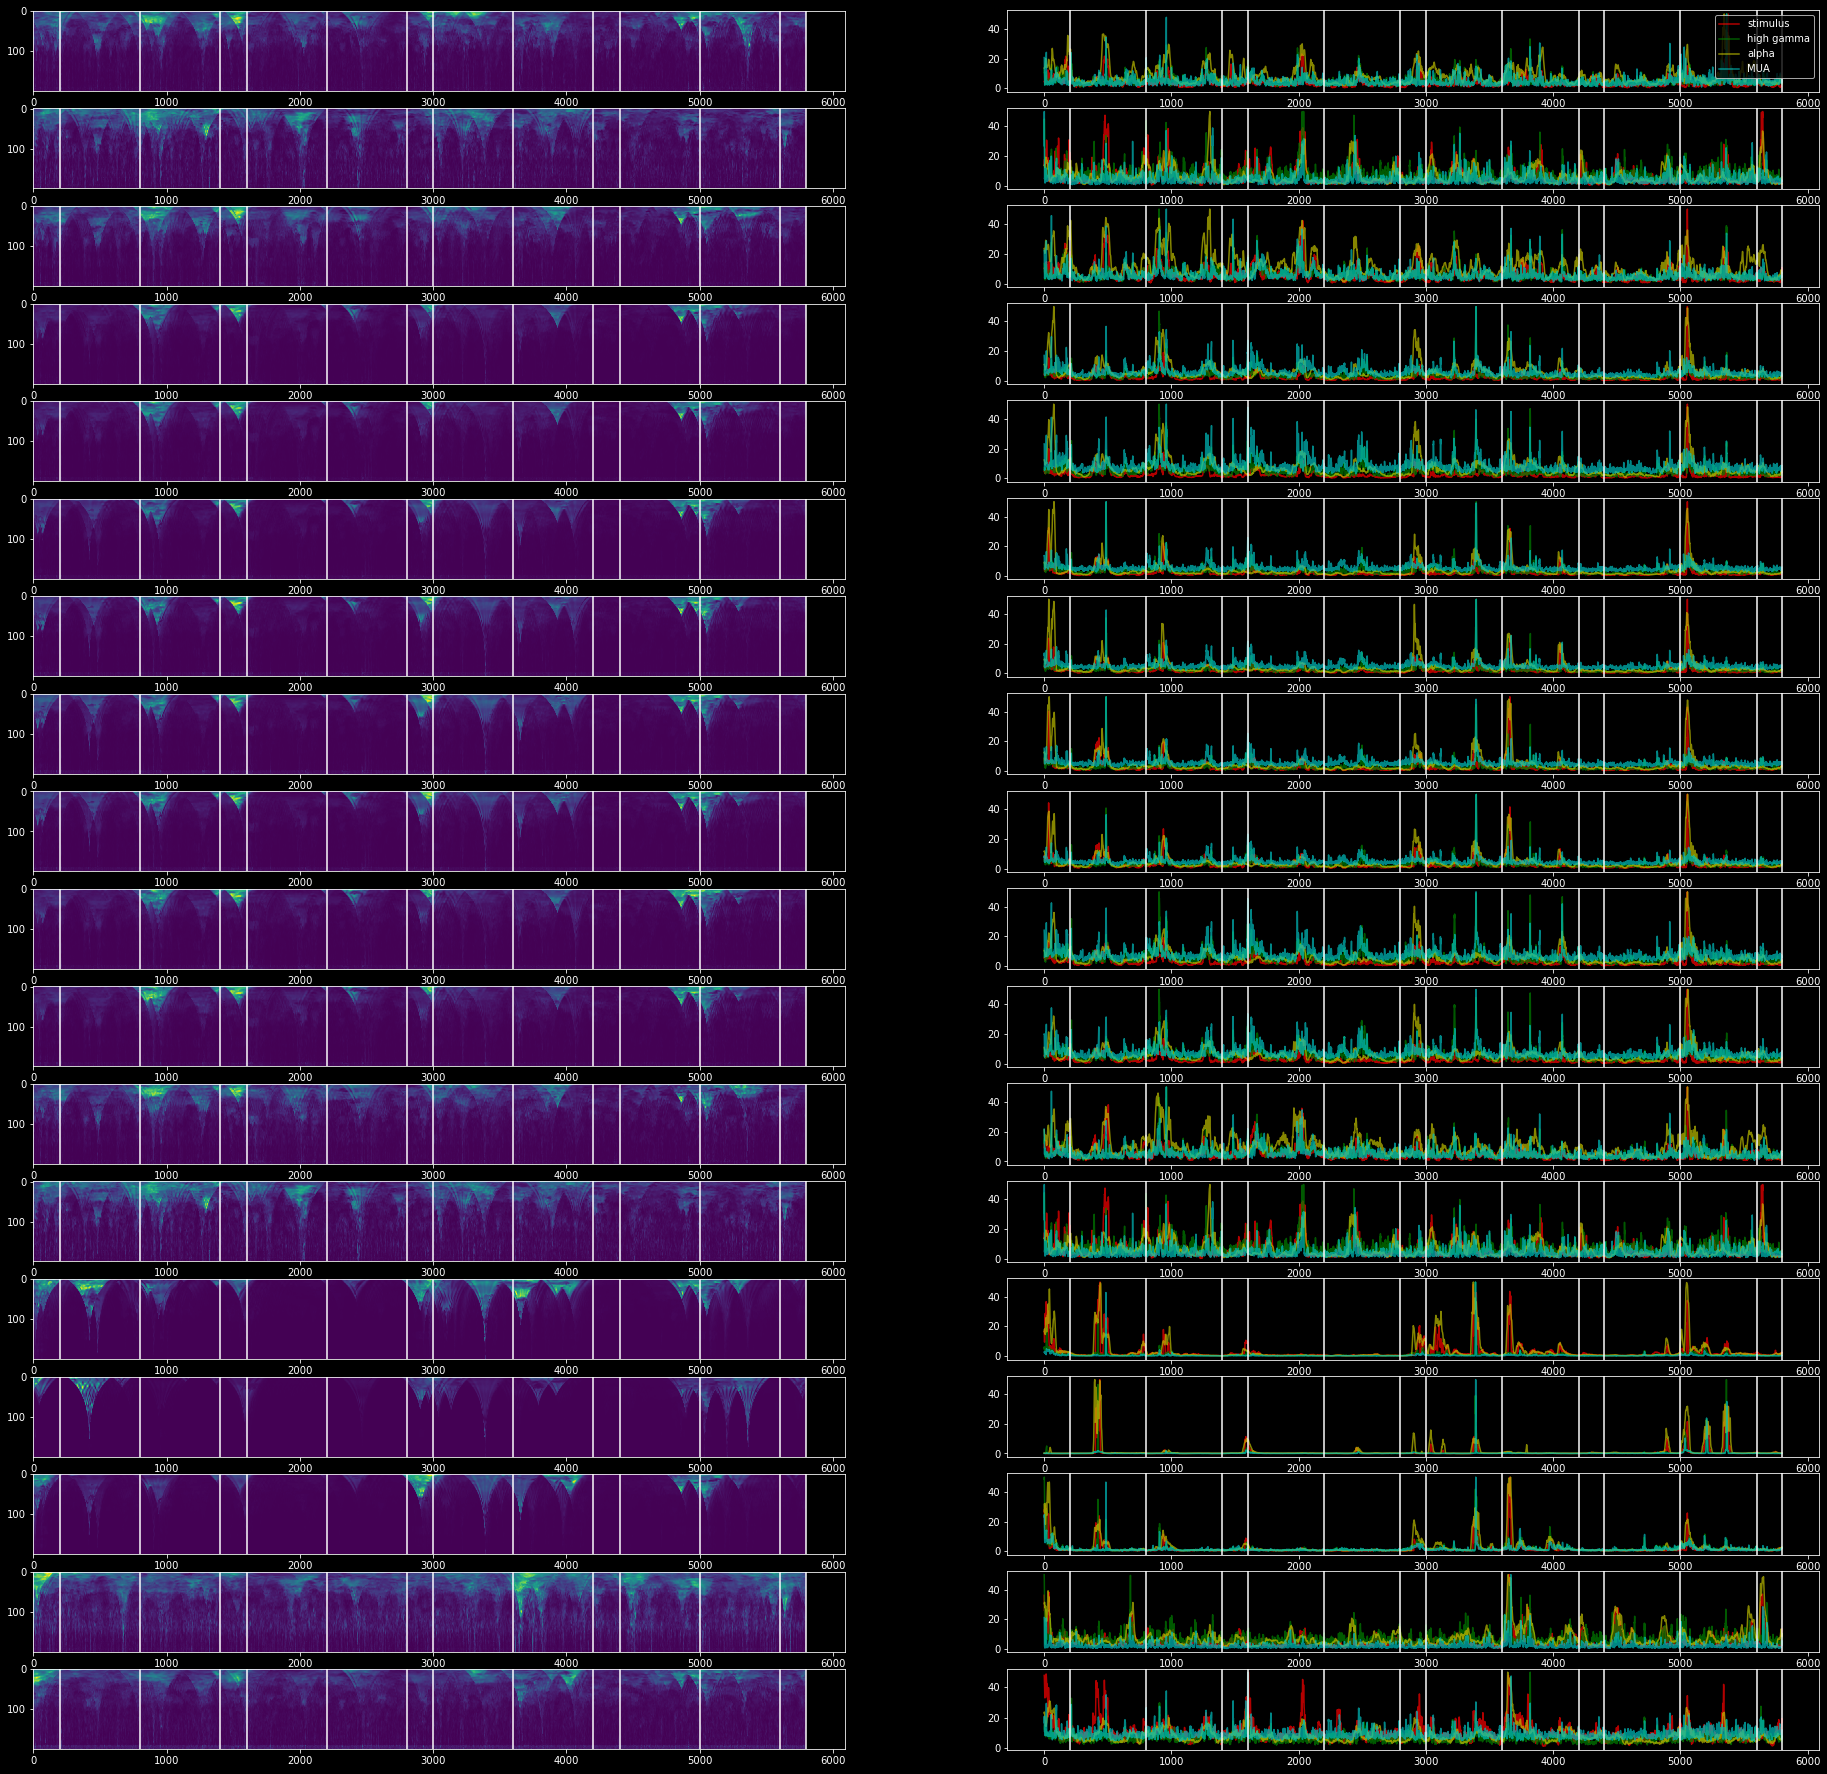

In [ ]:
# plt.plot(tfr_data[0,0,:,::10].T)
present_sample_rate = 100
single_run_dur = int(58*present_sample_rate)
stim_frequencies = (freqs < 16) & (freqs > 14)
hg_frequencies = (freqs < 120) & (freqs > 50)
alpha_frequencies = (freqs < 12) & (freqs > 8)
mua_frequencies = (freqs > 120)

f, axs = plt.subplots(tfr_data.shape[1], 2, figsize=(32, 32))
for k in range(tfr_data.shape[1]):  # electrodes
    tfr_m = np.zeros((tfr_data.shape[2], single_run_dur))
    for i, ch in enumerate(tfr_data[0, k]):  # frequencies
        rd = []
        for j in range(6):  # stim repeats
            start_j = int(j*single_run_dur)
            rd.append(ch[start_j:start_j+single_run_dur])
        rd = np.array(rd)
        rd /= rd.std(1)[:, np.newaxis]
        tfr_m[i] = np.median(rd, 0)
    axs[k,0].imshow(tfr_m, aspect=3)

    stim_power = tfr_m[stim_frequencies].mean(0)
    stim_power /= stim_power.max()
    axs[k,1].plot(stim_power*50, 'r', alpha=0.7, label='stimulus')
    hg_power = tfr_m[hg_frequencies].mean(0)
    hg_power /= hg_power.max()
    axs[k,1].plot(hg_power*50, 'g', alpha=0.7, label='high gamma')
    alpha_power = tfr_m[alpha_frequencies].mean(0)
    alpha_power /= alpha_power.max()
    axs[k,1].plot(alpha_power*50, 'y', alpha=0.7, label='alpha')
    mua_power = tfr_m[mua_frequencies].mean(0)
    mua_power /= mua_power.max()
    axs[k,1].plot(mua_power*50, 'c', alpha=0.7, label='MUA')
    if k == 0:
        axs[k,1].legend()

    for x in np.cumsum(durations_one_pRF_expt*present_sample_rate):
        axs[k, 0].axvline(x, c='w')
        axs[k, 1].axvline(x, c='w')
plt.savefig(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', f'_{target_el}.pdf')))


In [ ]:
indices_1r = np.r_[0,np.cumsum(durations_one_pRF_expt*present_sample_rate)]
ranges_1r = np.array([indices_1r[:-1], indices_1r[1:], bar_blank_bools]).T

all_ranges = np.zeros((ranges_1r.shape[0]*expts_in_run, 3), dtype=int)
for i in range(expts_in_run):
    all_ranges[i*ranges_1r.shape[0]:(i+1)*ranges_1r.shape[0]] = ranges_1r + np.array([ranges_1r[-1,1], ranges_1r[-1,1], 0])
    
# data per condition; bar or not?
blank_tfr, bar_tfr = [], [] 
for ar in all_ranges:
    if ar[-1] == 0: # blank
        blank_tfr.append(np.squeeze(tfr_data)[...,ar[0]:ar[1]])
    else:
        bar_tfr.append(np.squeeze(tfr_data)[...,ar[0]:ar[1]])
# reset to samples in last dimension        
blank_tfr = np.array(blank_tfr).transpose((1,2,3,0)).reshape((tfr_data.shape[1],tfr_data.shape[2],-1))
bar_tfr = np.array(bar_tfr).transpose((1,2,3,0)).reshape((tfr_data.shape[1],tfr_data.shape[2],-1))        

In [ ]:
# per second psd
bar_tfr_ps = np.array([bar_tfr[...,x:x+present_sample_rate].mean(-1) for x in range(0,bar_tfr.shape[-1], present_sample_rate)])
blank_tfr_ps = np.array([blank_tfr[...,x:x+present_sample_rate].mean(-1) for x in range(0,blank_tfr.shape[-1], present_sample_rate)])
bar_tfr_ps.shape

(288, 18, 200)

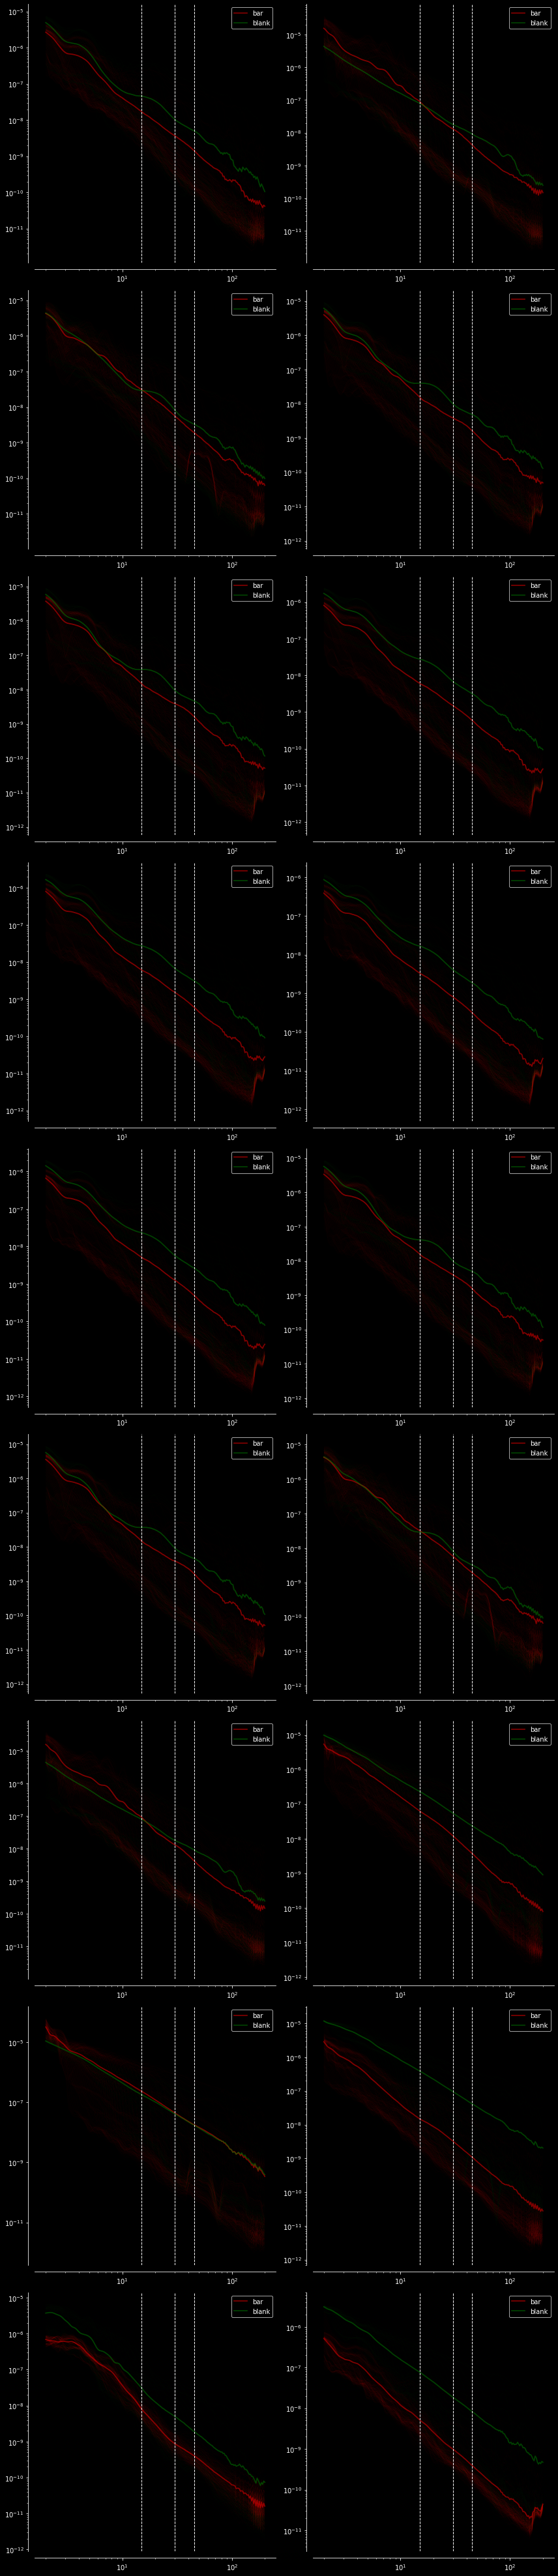

In [ ]:
f, axs = plt.subplots(tfr_data.shape[1]//2, 2, figsize=(12,55))
for el in range(tfr_data.shape[1]):
    row=el//2
    col=el%2
    for x in range(bar_tfr_ps.shape[0]): # bar_tfr.shape[-1]
        axs[row,col].loglog(freqs, bar_tfr_ps[x,el,:], c='r', lw=0.25, alpha=0.05)
    for x in range(blank_tfr_ps.shape[0]): # bar_tfr.shape[-1]
        axs[row,col].loglog(freqs, blank_tfr_ps[x,el,:], c='g', lw=0.25, alpha=0.05)
    axs[row,col].loglog(freqs, bar_tfr_ps[:,el,:].mean(0), c='r', ls='-', lw=1.75, alpha=0.5, label='bar')
    axs[row,col].loglog(freqs, blank_tfr_ps[:,el,:].mean(0), c='g', ls='-', lw=1.75, alpha=0.5, label='blank')
    axs[row,col].axvline(x=15, c='w', ls='--', lw=1)
    axs[row,col].axvline(x=30, c='w', ls='--', lw=1)
    axs[row,col].axvline(x=45, c='w', ls='--', lw=1)
    axs[row,col].legend()
    # axs[el].set_aspect('equal')

sns.despine(fig=f, offset=10)
plt.tight_layout()
plt.savefig(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', f'_{target_el}_psd.bar-blank.pdf')))